# Facial Keypoint Labelling via CNN


In [1]:
import json
from pathlib import Path
from typing import Dict, List, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm


from model.consts import FLOAT_T
from model.impute import ImageImputer, KeypointImputer
from model.load import load_image, load_images


2025-04-29 20:16:40.201117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745972200.212970   11292 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745972200.216631   11292 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745972200.226589   11292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745972200.226600   11292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745972200.226601   11292 computation_placer.cc:177] computation placer alr

In [2]:
print("TensorFlow version: ", tf.__version__)
print("GPU built with TensorFlow: ", tf.test.is_built_with_cuda())
print("Can access GPU: ", tf.config.experimental.list_physical_devices("GPU"))


TensorFlow version:  2.19.0
GPU built with TensorFlow:  True
Can access GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_path = Path("data") / "prashantarorat" / "facial-key-point-data"
labels_path = data_path / "all_data.json"
images_path = data_path / "images"

## Load Data


In [4]:
with open(labels_path, "rb") as f:
    labels = json.load(f)

labels["0"]

{'file_name': '00000.png',
 'face_landmarks': [[73.7203007518797, 237.71428571428572],
  [81.03458646616541, 276.2105263157895],
  [88.34887218045112, 312.78195488721803],
  [102.20751879699247, 347.81353383458645],
  [128.0, 375.1458646616541],
  [161.10676691729324, 393.2390977443609],
  [198.44812030075187, 405.17293233082705],
  [229.63007518796994, 418.26165413533835],
  [259.27218045112784, 420.57142857142856],
  [284.29473684210524, 412.8721804511278],
  [305.46766917293235, 396.70375939849623],
  [329.7203007518797, 381.30526315789473],
  [349.73834586466165, 357.82255639097747],
  [362.0571428571429, 329.33533834586467],
  [366.6766917293233, 298.53834586466166],
  [367.44661654135336, 267.74135338345866],
  [367.8315789473684, 237.3293233082707],
  [134.1593984962406, 211.9218045112782],
  [158.02706766917294, 196.13834586466166],
  [188.05413533834587, 188.05413533834587],
  [221.1609022556391, 188.82406015037594],
  [250.03308270676692, 197.29323308270676],
  [284.679699248

In [5]:
label_keys = sorted(list(labels.keys()), key=lambda x: int(x))

label_keys[:10]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

(512, 512, 3)


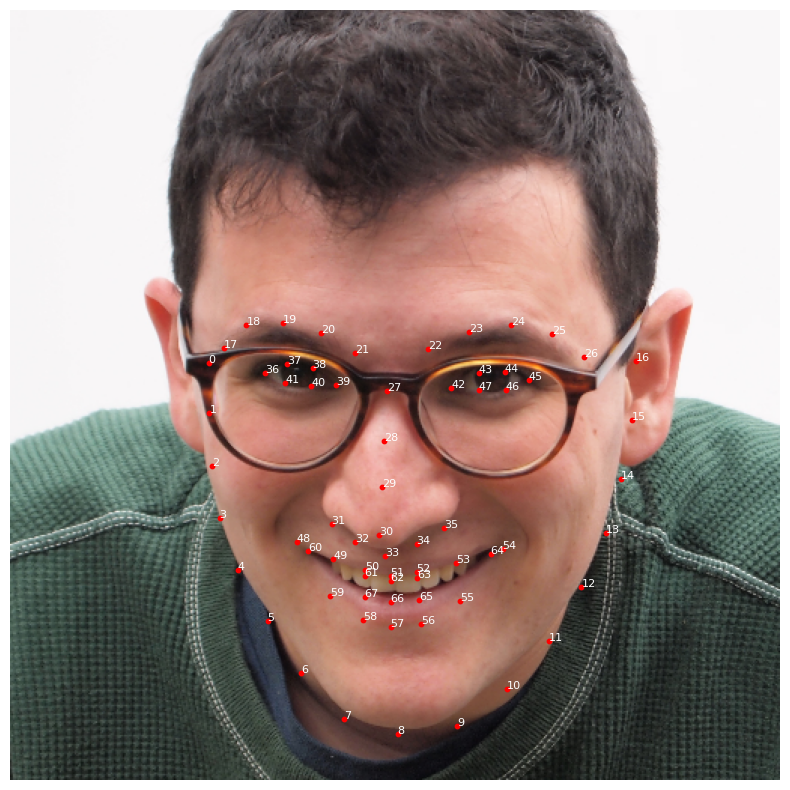

In [6]:
im_index = 100

img_file_path = images_path / labels[label_keys[im_index]]["file_name"]
key_points = np.array(labels[label_keys[im_index]]["face_landmarks"]).T

img = cv2.imread(str(img_file_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(10, 10))
plt.imshow(img)
for i, (x, y) in enumerate(zip(key_points[0], key_points[1])):
    plt.scatter(x, y, c="r", s=10)
    plt.text(x, y, str(i), color="white", fontsize=8)
plt.axis("off")
plt.show()

In [7]:
# Only use a handful of keypoints
# key_point_indices = [1, 8, 15, 17, 21, 22, 26, 36, 39, 42, 45, 30, 31, 35, 48, 54]
key_point_indices = list(range(68))

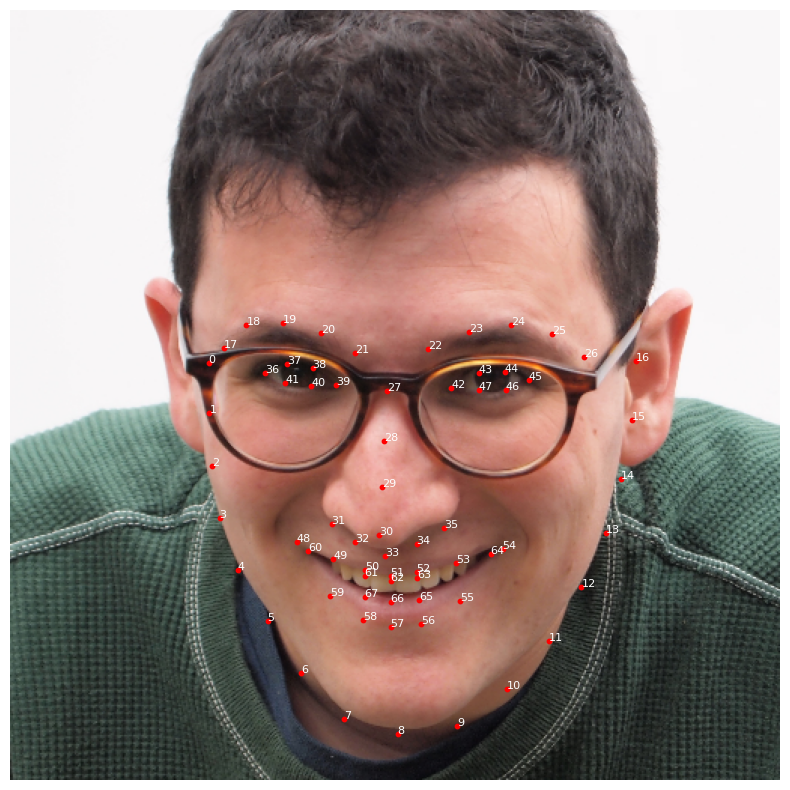

In [8]:
filtered_key_points = np.array(labels[label_keys[im_index]]["face_landmarks"])[
    key_point_indices
].T

plt.figure(figsize=(10, 10))
plt.imshow(img)
for i, (x, y) in enumerate(zip(filtered_key_points[0], filtered_key_points[1])):
    plt.scatter(x, y, c="r", s=10)
    plt.text(x, y, str(i), color="white", fontsize=8)
plt.axis("off")
plt.show()

## Library


In [ ]:
IM_WIDTH = 224


# class ImageImputer:
#     im_max = 255.0

#     def forward(self, x):
#         return x / self.im_max

#     def backward(self, x):
#         return x * self.im_max


# class KeypointImputer:
#     im_width = 512.0
#     im_height = 512.0

#     def forward(self, x):
#         return x / self.im_width

#     def backward(self, x):
#         return x * self.im_width


# def load_image(img_path, width=IM_WIDTH, height=IM_WIDTH, channels=3):
#     img = cv2.imread(str(img_path))

#     kernel_width = int(np.min(img.shape) / IM_WIDTH) // 2 * 2 + 1
#     img = cv2.GaussianBlur(img, (kernel_width, kernel_width), 0)

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = (
#         cv2.resize(img, (width, height))
#         .reshape(width, height, channels)
#         .astype(FLOAT_T)
#     )

#     return ImageImputer().forward(img)


# def load_images(img_paths, width=IM_WIDTH, height=IM_WIDTH, channels=3):
#     images = np.zeros((len(img_paths), width, height, channels), dtype=FLOAT_T)
#     for i, img_path in enumerate(tqdm(img_paths)):
#         images[i] = load_image(img_path, width, height, channels)
#     return images


# def load_images_as_tensor(img_paths, width=IM_WIDTH, height=IM_WIDTH, channels=1):
#     images = np.zeros((len(img_paths), width, height, channels), dtype=FLOAT_T)
#     for i, img_path in enumerate(tqdm(img_paths)):
#         images[i] = load_image(img_path, width, height, channels)
#     return torch.from_numpy(images).permute(0, 3, 1, 2).to(mps_device)


image_imputer = ImageImputer(
    im_width=IM_WIDTH,
    im_height=IM_WIDTH,
    crop=True,
    resize=True,
)

keypoint_imputer = KeypointImputer(
    native_im_width=512,
    native_im_height=512,
)


(224, 224, 3)
0.039215688 0.99215686


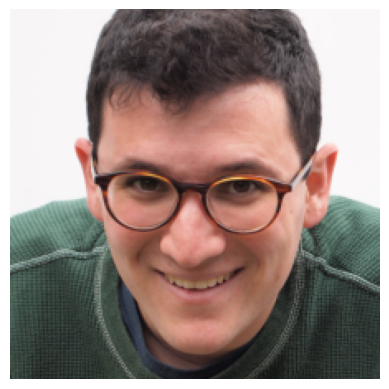

In [10]:
im = load_image(img_file_path)
print(im.shape)
print(np.min(im), np.max(im))

plt.figure()
plt.imshow(im)
plt.axis("off")
plt.show()

In [11]:
def augment_image(
    image: np.ndarray, keypoints: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    # Randomly flip the image horizontally
    flip = np.random.rand() > 0.5
    if flip:
        image = cv2.flip(image, 1)

    # Randomly rotate the image
    angle = np.random.uniform(-15, 15)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    scale_x = np.random.uniform(0.9, 1.1)
    scale_y = np.random.uniform(0.9, 1.1)
    rotation_matrix[0, 0] *= scale_x
    rotation_matrix[1, 1] *= scale_y

    image = cv2.warpAffine(
        image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT
    )

    # Apply the same transformation to keypoints

    if keypoints is not None:
        rotation_matrix = cv2.getRotationMatrix2D((512.0 / 2, 512.0 / 2), angle, 1.0)
        rotation_matrix[0, 0] *= scale_x
        rotation_matrix[1, 1] *= scale_y

        _kp = keypoints.T.copy()
        if flip:
            _kp[:, 0] = 512.0 - _kp[:, 0]
        _kp = np.concatenate([_kp, np.ones((_kp.shape[0], 1), dtype=_kp.dtype)], axis=1)
        rotation_matrix = np.concatenate(
            [rotation_matrix, np.array([[0, 0, 1]])], axis=0
        )
        _kp = rotation_matrix @ _kp.T
        _kp = _kp / _kp[2, :]
        _kp = _kp[:2, :].T

        # _kp = np.clip(_kp, 0, 512.0)

        return image, _kp.T

    return image, None


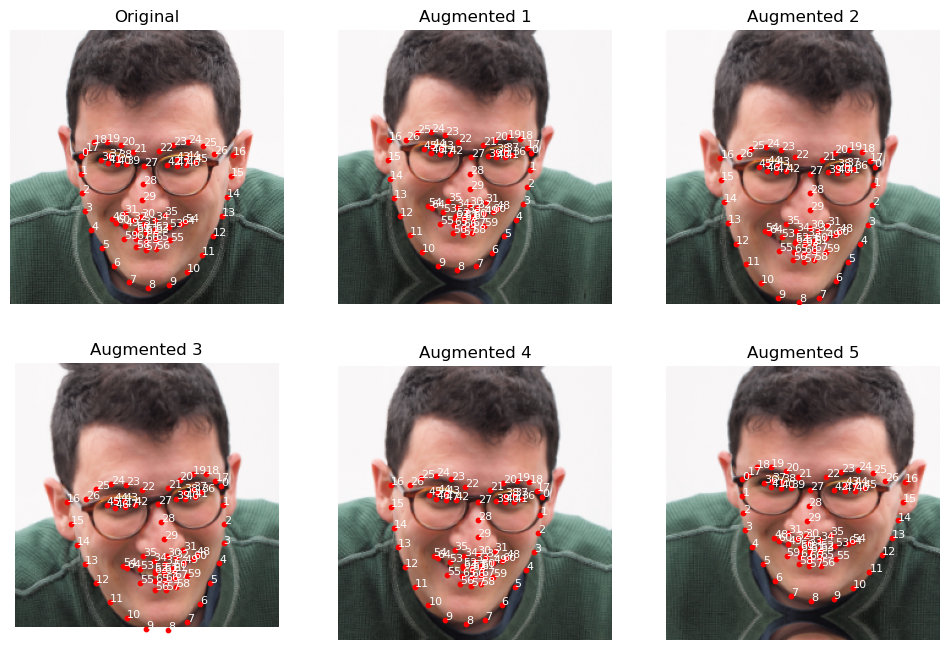

In [12]:
variations = [augment_image(im, filtered_key_points) for i in range(5)]

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(im)
kps = filtered_key_points * IM_WIDTH / 512.0
for j, (x, y) in enumerate(zip(kps[0], kps[1])):
    plt.scatter(x, y, c="r", s=10)
    plt.text(x, y, str(j), color="white", fontsize=8)
plt.title("Original")
plt.axis("off")

for i, (img, kps) in enumerate(variations):
    plt.subplot(2, 3, i + 2)
    plt.imshow(img)

    kps = kps * IM_WIDTH / 512.0

    for j, (x, y) in enumerate(zip(kps[0], kps[1])):
        plt.scatter(x, y, c="r", s=10)
        plt.text(x, y, str(j), color="white", fontsize=8)
    plt.title(f"Augmented {i + 1}")

    plt.axis("off")
plt.show()

In [13]:
load_images([img_file_path]).shape

100%|██████████| 1/1 [00:00<00:00, 78.61it/s]


(1, 224, 224, 3)

In [14]:
# Prepare train data
train_keys = label_keys[: int(len(label_keys) * 0.8)]
test_keys = label_keys[int(len(label_keys) * 0.8) :]


In [15]:
train_img_paths = [images_path / labels[k]["file_name"] for k in train_keys]
train_keypoints = np.array(
    [np.array(labels[k]["face_landmarks"])[key_point_indices] for k in train_keys],
    dtype=FLOAT_T,
).T.reshape(len(key_point_indices) * 2, -1)
print(train_keypoints.shape)
train_keypoints = keypoint_imputer.forward(train_keypoints)

print(np.min(train_keypoints), np.max(train_keypoints))

train_ims = load_images(train_img_paths, width=IM_WIDTH, height=IM_WIDTH)
train_labels = train_keypoints.astype(FLOAT_T).T

train_ims.shape, train_labels.shape

(136, 4000)
-0.012273902 1.0286989


100%|██████████| 4000/4000 [00:26<00:00, 150.91it/s]


((4000, 224, 224, 3), (4000, 136))

In [16]:
# NUM_VARIATIONS = 1

# train_ims_aug = np.zeros(
#     (len(train_ims) * NUM_VARIATIONS, IM_WIDTH, IM_WIDTH, 3),
#     dtype=np.float32,
# )
# train_labels_aug = np.zeros(
#     (len(train_labels) * NUM_VARIATIONS, len(key_point_indices) * 2),
#     dtype=np.float32,
# )

# for i in range(NUM_VARIATIONS):
#     for j, (img, keypoints) in enumerate(
#         tqdm(zip(train_ims, train_labels), total=len(train_ims))
#     ):
#         keypoints = keypoint_imputer.backward(keypoints).reshape(2, -1)
#         img, keypoints = augment_image(img, keypoints)
#         keypoints = keypoint_imputer.forward(keypoints).reshape(-1)
#         train_ims_aug[i * len(train_ims) + j] = img
#         train_labels_aug[i * len(train_labels) + j] = keypoints

# print(train_labels_aug[:10])

In [17]:
# # Plot first augmented image
# plt.figure(figsize=(5, 5))
# plt.imshow(train_ims_aug[0])
# _kp = keypoint_imputer.backward(train_labels_aug).reshape(2, -1)[0] * IM_WIDTH / 512

# for j, (x, y) in enumerate(zip(_kp[0], _kp[1])):
#     plt.scatter(x, y, c="r", s=10)
#     plt.text(x, y, str(j), color="white", fontsize=8)
# plt.title("Augmented Image")
# plt.axis("off")
# plt.show()

In [18]:
test_img_paths = [images_path / labels[k]["file_name"] for k in test_keys]
test_keypoints = np.array(
    [np.array(labels[k]["face_landmarks"])[key_point_indices] for k in test_keys],
    dtype=FLOAT_T,
).T.reshape(len(key_point_indices) * 2, -1)
print(test_keypoints.shape)
test_keypoints = keypoint_imputer.forward(test_keypoints)

print(np.min(test_keypoints), np.max(test_keypoints))

test_ims = load_images(test_img_paths, width=IM_WIDTH, height=IM_WIDTH)
test_labels = test_keypoints.astype(np.float32).T

test_ims.shape, test_labels.shape

(136, 1000)
0.03692115 1.0287465


100%|██████████| 1000/1000 [00:07<00:00, 138.52it/s]


((1000, 224, 224, 3), (1000, 136))

## Model Architecture


In [19]:
num_keypoints = len(key_point_indices)

model = models.Sequential()
model.add(
    layers.Conv2D(64, (5, 5), activation="relu", input_shape=(IM_WIDTH, IM_WIDTH, 3))
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512))
model.add(layers.Dense(num_keypoints * 2))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy"],
)

model.summary()

/home/thomas/miniconda3/envs/cs445/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745972240.117237   11292 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    88,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 136)            │        69,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,426,568 (341.14 MB)

 Trainable params: 89,426,568 (341.14 MB)

 Non-trainable params: 0 (0.00 B)

## Training


In [20]:
tf.keras.backend.clear_session()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=25,
    restore_best_weights=True,
)

history = model.fit(
    train_ims,
    train_labels,
    epochs=100,
    batch_size=16,
    verbose=1,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb,
    ],
)


2025-04-29 20:17:21.380436: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1926758400 exceeds 10% of free system memory.
2025-04-29 20:17:22.242306: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1926758400 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1745972243.479046   11382 service.cc:152] XLA service 0x7f5cb40069a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745972243.479079   11382 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-29 20:17:23.501875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745972243.636204   11382 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 20:17:24.248031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_419_0', 232 bytes spill stores, 388 bytes spill loads

2025-04-29 20:17:24.310551: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41

  5/200 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.0000e+00 - loss: 9.1395

I0000 00:00:1745972248.934490   11382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.3169 - loss: 0.8906 - val_accuracy: 0.6862 - val_loss: 0.0015
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6510 - loss: 0.0013 - val_accuracy: 0.7487 - val_loss: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5916 - loss: 9.7174e-04 - val_accuracy: 0.4412 - val_loss: 0.0012
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5762 - loss: 0.0011 - val_accuracy: 0.7100 - val_loss: 6.3678e-04
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5810 - loss: 6.7960e-04 - val_accuracy: 0.7262 - val_loss: 4.9512e-04
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6182 - loss: 5.3543e-04 - val_accuracy: 0.6400 - val_loss: 5.0200e-04
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6564 - loss: 4.3454e-04 - val_accuracy: 0.7663 - val_loss: 4.1859e-04
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 

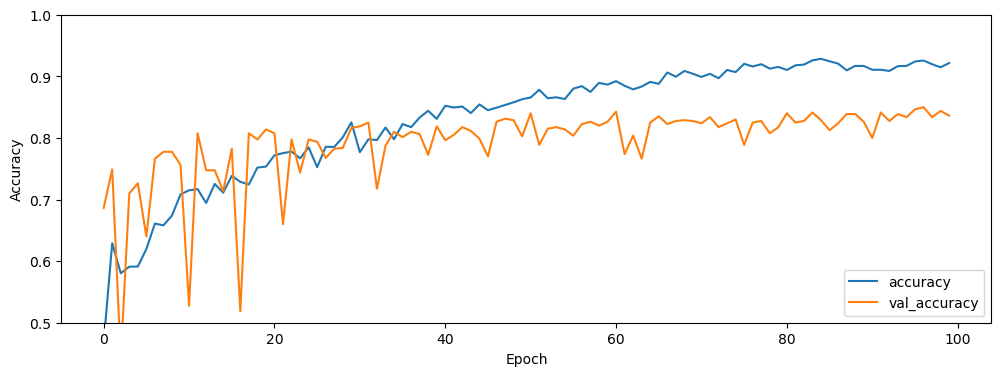

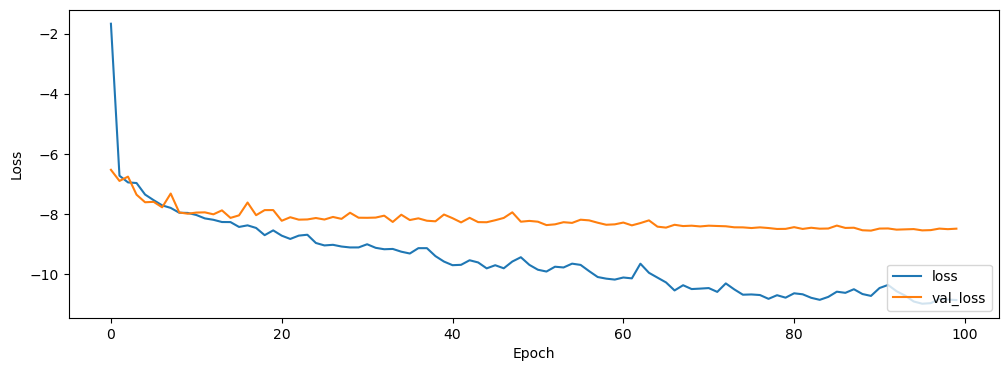

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

plt.figure(figsize=(12, 4))
plt.plot(np.log(history.history["loss"]), label="loss")
plt.plot(np.log(history.history["val_loss"]), label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower right")

plt.show()


## Evaluation


In [22]:
test_loss, test_acc = model.evaluate(test_ims, test_labels, verbose=2)

2025-04-29 20:30:22.451470: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109_0', 468 bytes spill stores, 1028 bytes spill loads

2025-04-29 20:30:22.588856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 488 bytes spill stores, 488 bytes spill loads

2025-04-29 20:30:22.593580: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 608 bytes spill stores, 608 bytes spill loads

2025-04-29 20:30:22.601195: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_109', 832 bytes spill stores, 832 bytes spill loads

2025-04-29 20:30:23.226197: I ext

32/32 - 6s - 197ms/step - accuracy: 0.8200 - loss: 1.9217e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


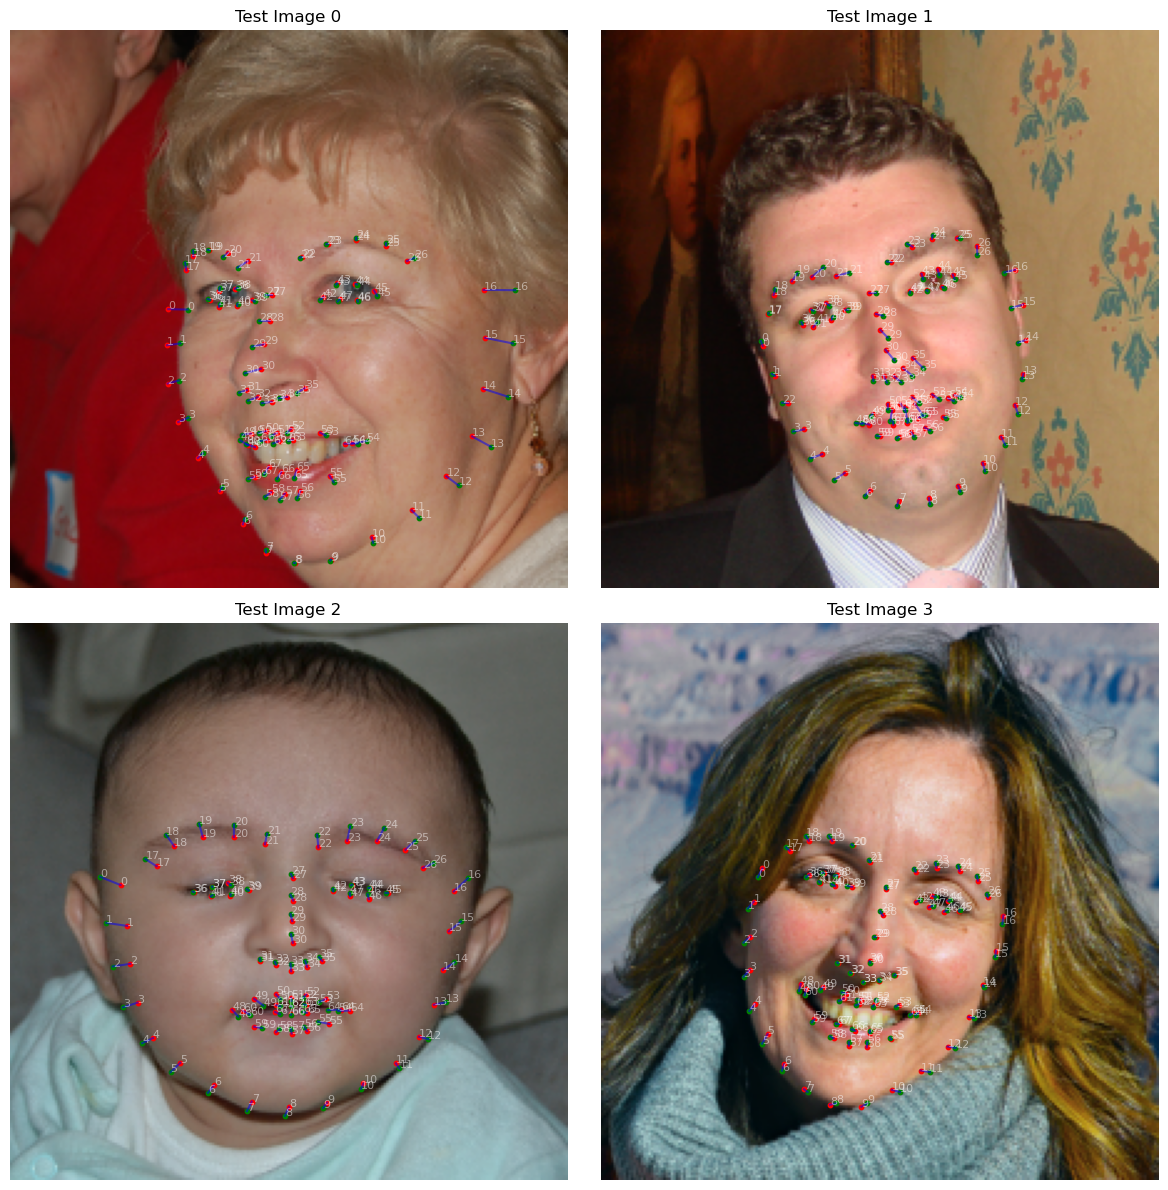

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

keypoint_scale = 512.0 / IM_WIDTH

for idx, ax in enumerate(axes.flatten()):
    test_index = idx
    test_obj = labels[test_keys[test_index + 8]]

    test_im = load_image(
        images_path / test_obj["file_name"],
        width=IM_WIDTH,
        height=IM_WIDTH,
    )
    test_keypoint = np.array(test_obj["face_landmarks"])
    test_keypoint = np.array(test_keypoint[key_point_indices]).reshape(-1, 2)

    keypoints = model.predict(test_im.reshape(1, IM_WIDTH, IM_WIDTH, 3))
    keypoints = keypoint_imputer.backward(keypoints).reshape(2, -1).T

    ax.imshow(test_im)

    for i, (x, y) in enumerate(keypoints / keypoint_scale):
        ax.scatter(x, y, c="r", s=10)
        ax.text(x, y, str(i), color="white", fontsize=8, alpha=0.5)

    for i, (x, y) in enumerate(test_keypoint / keypoint_scale):
        ax.scatter(x, y, c="g", s=10)
        ax.text(x, y, str(i), color="white", fontsize=8, alpha=0.5)

    # Plot line between expected and actual
    for i, ((x1, y1), (x2, y2)) in enumerate(zip(test_keypoint, keypoints)):
        x1 = x1 / keypoint_scale
        y1 = y1 / keypoint_scale
        x2 = x2 / keypoint_scale
        y2 = y2 / keypoint_scale
        ax.plot([x1, x2], [y1, y2], c="b", alpha=0.5)

    ax.axis("off")
    ax.set_title(f"Test Image {test_index}")

plt.tight_layout()
plt.show()
